In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the Intel Image Classification dataset
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 342M/346M [00:04<00:00, 44.2MB/s]
100% 346M/346M [00:04<00:00, 80.4MB/s]


In [6]:
!unzip -q intel-image-classification.zip -d ./intel-image-classification

In [7]:
# Importing necessary libraries
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
# Importing scikit-learn metrics for model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# Importing OS module for file and directory operations
import os
from os import walk
# Importing TensorFlow for deep learning tasks
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.backend.clear_session()


In [8]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}

In [9]:
dir_pred = '/content/intel-image-classification/seg_pred/seg_pred'

In [10]:
dir_test = '/content/intel-image-classification/seg_test/seg_test'
dir_train =  '/content/intel-image-classification/seg_train/seg_train'

In [11]:
IMAGE_SHAPE = (150, 150)
BATCH_SIZE = 32
print('Training images:')
train_data = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical")

print('Testing images:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(dir_test,
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical")

Training images:
Found 14034 files belonging to 6 classes.
Testing images:
Found 3000 files belonging to 6 classes.


In [12]:
# read in the names of the images in the prediction set
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


In [13]:
#helpful for organizing image file names based on class labels
def read_image_names_class(dpath):
    fnames = {}
    x, dirnames, y = next(walk(dpath))
    for d in dirnames:
        _,_,temp = next(walk(os.path.join(dpath,d)))
        fnames[classes[d]] = temp

    return dirnames, fnames
#This function provides a summary of class distribution in the dataset, including the count of instances, cumulative count, and class names.
def check_class_imbalance(fnames):
    count = 0
    class_summary = {}
    for key,value in fnames.items():
        count = count + len(value)
        class_summary[key] = len(value)

    summary = pd.DataFrame.from_dict(class_summary, orient='index', columns=["Count"])
    summary['CumCount'] = np.cumsum(summary['Count'])
    summary['Class'] = summary.index
    summary['Class'] = summary['Class'].apply(class_from_key)

    return summary
#This function is likely used in the context of converting numerical class labels to their corresponding class names
def class_from_key(x):
    for key, value in classes.items():
        if x == value:
            return key
#This function allows you to easily obtain a random sample of image file paths from a specific class
def sample_images_from_class(nsample, classname, path, fnames):
    sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
    spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]

    return spath
#This function generates a grid of subplots, with each column representing a class and each row containing a random sample of images from that class
def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))

    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)
#This function allows you to obtain a random sample of image file paths from a set of prediction images
def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:
        spj.append(os.path.join(path, fnames[sp]))

    return spj
#This function is useful for visually inspecting a random sample of prediction images.
def plot_sampled_prediction_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)

    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')
#This function can be useful for evaluating the performance of a model on a given dataset by comparing the true and predicted labels.
def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))

    return ytrue, ypred
# This function is useful for visualizing the performance of a classification model through a confusion matrix.
def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))
# This function can be used to read an image, prepare it for prediction, make predictions using a given model, and visualize the results
def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')

    parr = tf.keras.preprocessing.image.img_to_array(img)
    tparr = tf.expand_dims(parr, axis=0)

    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]

    sns.barplot(x=x,y=y,ax=ax2)

    return pred

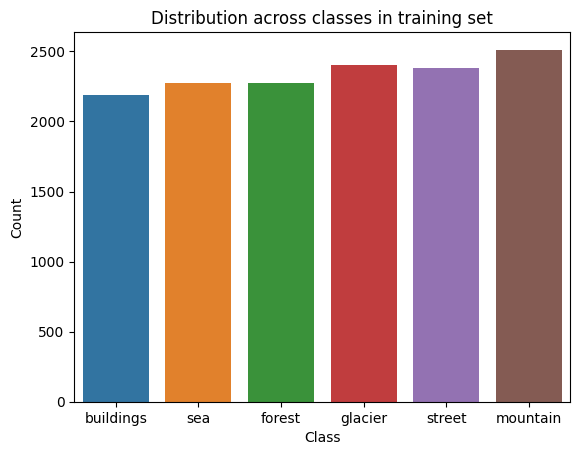

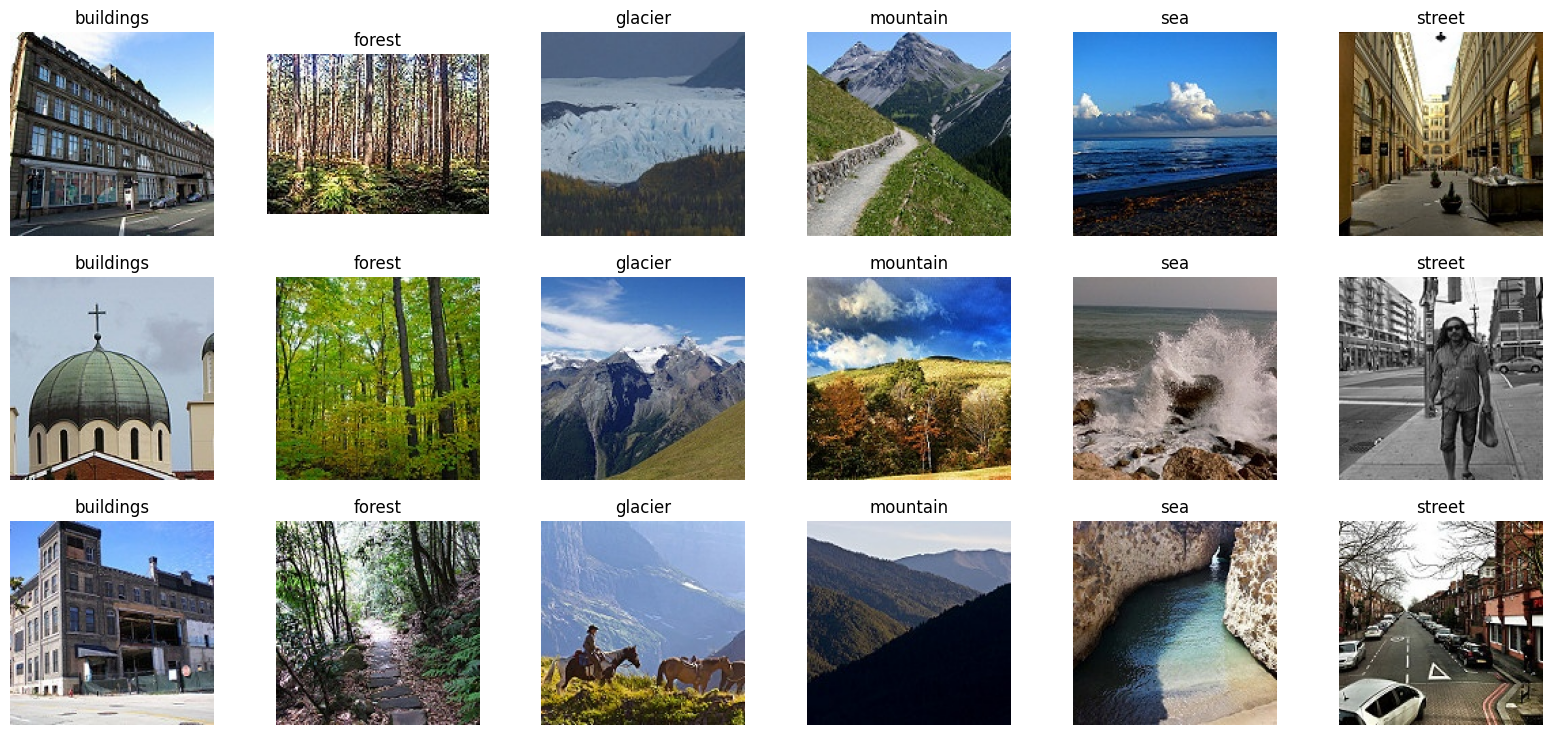

In [14]:
# Get directory names and file names for the training set
dirnames_train, fnames_train = read_image_names_class(dir_train)

# Check class imbalance and create a summary
train_summary = check_class_imbalance(fnames_train)

# Display the first 10 rows of the class summary
train_summary.head(10)

# Create a bar plot to visualize the distribution across classes in the training set
sns.barplot(data=train_summary, x='Class', y='Count').set_title("Distribution across classes in training set")

# Plot sampled images from the training set
plot_sampled_images(dir_train, fnames_train)

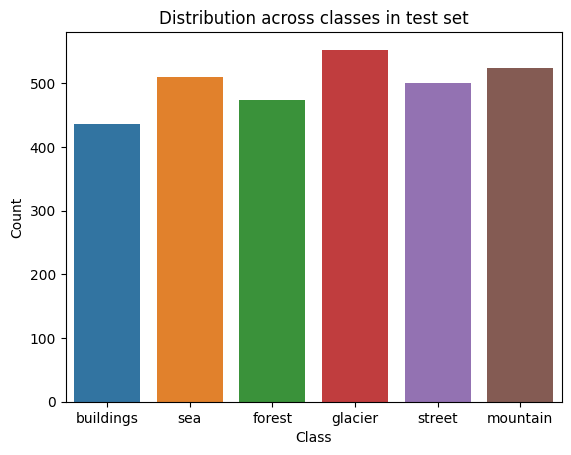

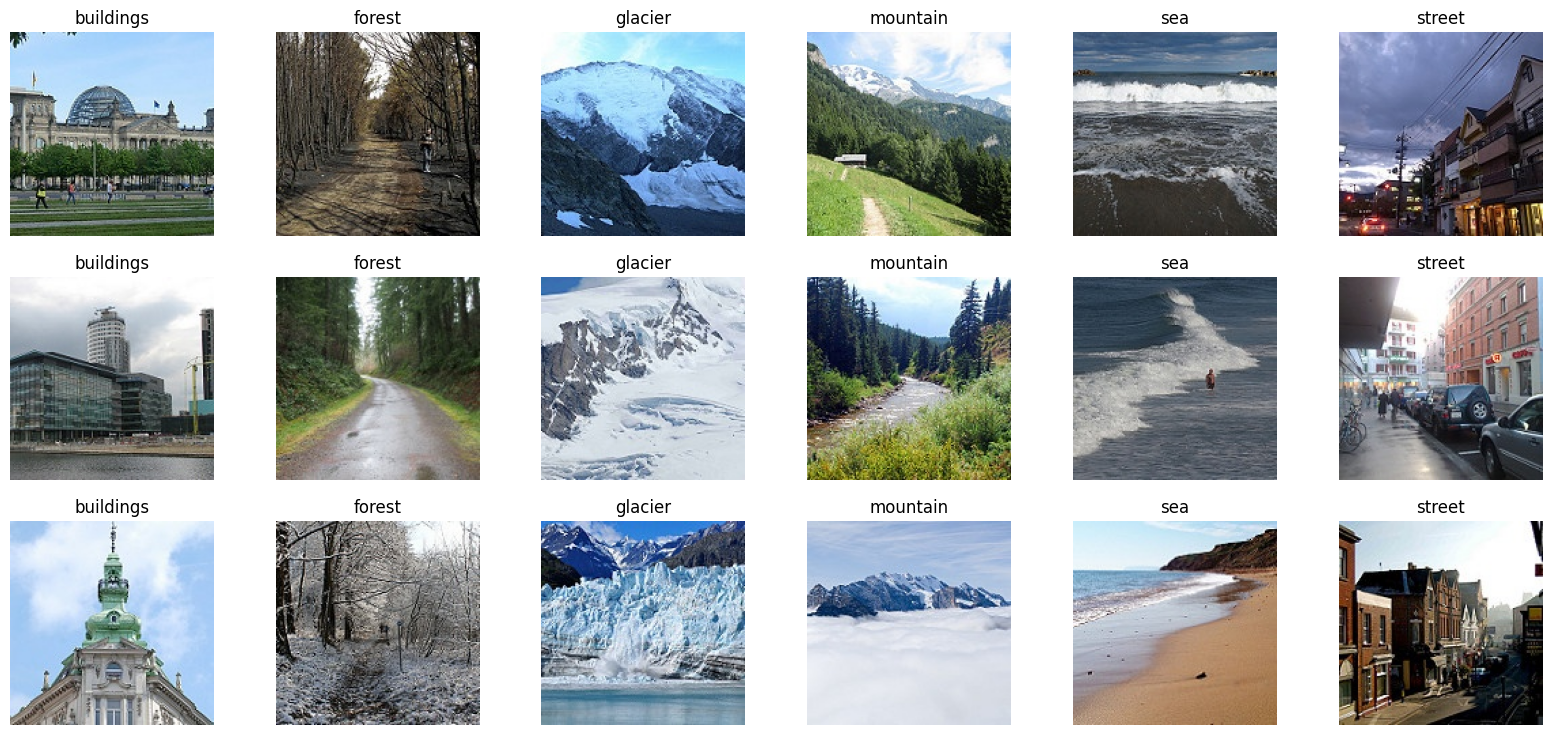

In [15]:
# Get directory names and file names for the test set
dirnames_test, fnames_test = read_image_names_class(dir_test)

# Check class imbalance and create a summary for the test set
test_summary = check_class_imbalance(fnames_test)

# Display the first 10 rows of the class summary for the test set
test_summary.head(10)

# Create a bar plot to visualize the distribution across classes in the test set
sns.barplot(data=test_summary, x='Class', y='Count').set_title("Distribution across classes in test set")

# Plot sampled images from the test set
plot_sampled_images(dir_test, fnames_test)

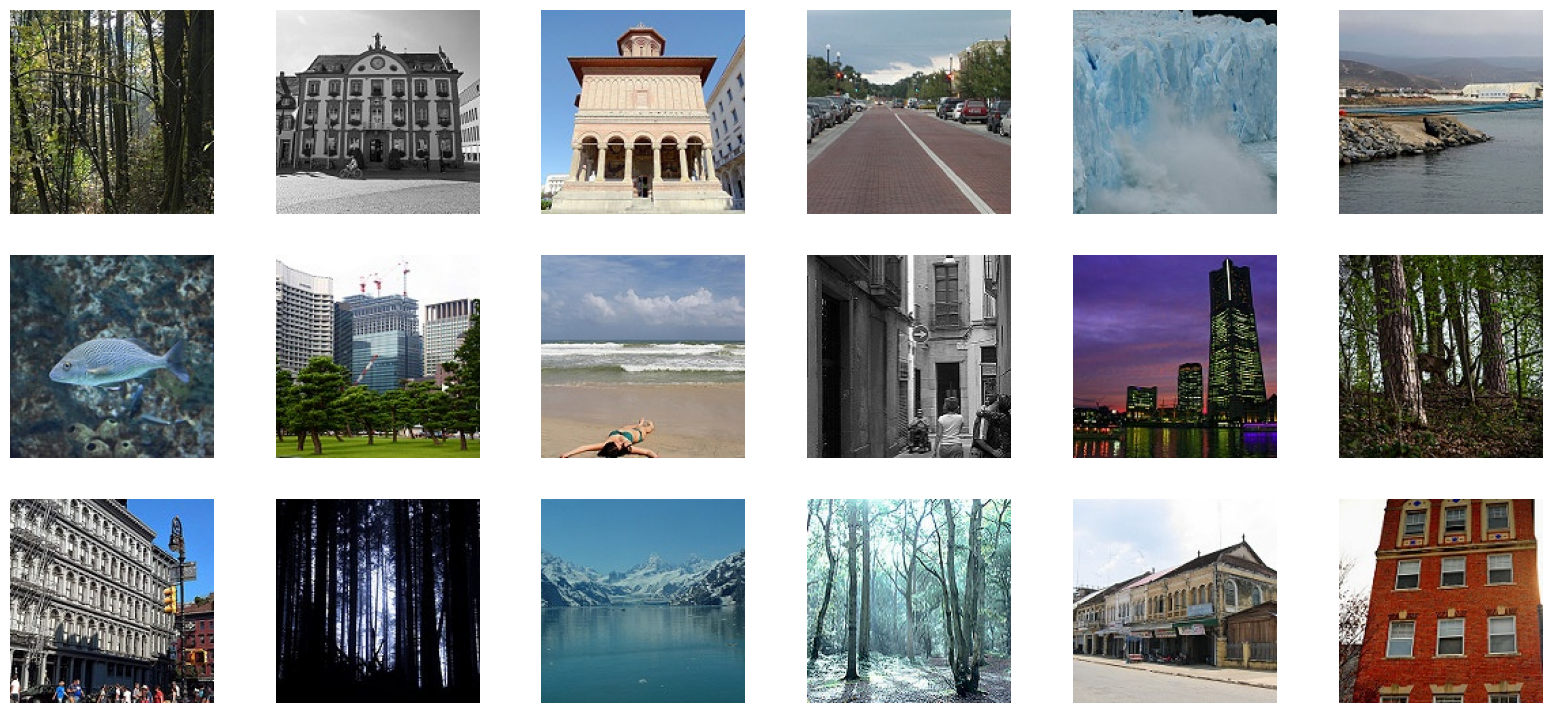

In [16]:
# Assuming the existence of the function plot_sampled_prediction_images
plot_sampled_prediction_images(dir_pred, fnames_pred)


In [17]:
batch = 32
shuff = True

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir_train,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=(150, 150),
    batch_size=batch,
    shuffle=shuff,
    label_mode='categorical'
)

# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir_train,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=(150, 150),
    batch_size=batch,
    shuffle=shuff,
    label_mode='categorical'
)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, and prefetch operations for the training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch operations for the validation dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [19]:
train_model = False

In [20]:
if train_model:
    mod = tf.keras.models.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (150,150,3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1,0.3)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(1,1), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=6, activation='softmax')
            ])

    mets = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(),
        tf.metrics.TrueNegatives(), tf.metrics.TruePositives(), tf.metrics.FalseNegatives(), tf.metrics.FalsePositives()]
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

    earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, restore_best_weights=True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

    # traindat_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2,
    #                                                           brightness_range=(-2.,2.), zoom_range=0.2, horizontal_flip=True,
    #                                                           rescale=1./255, validation_split=0.2)
    # testdat_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


    # train_ds = traindat_aug.flow_from_directory(dir_train, target_size=(150,150), batch_size=batch, class_mode='categorical', subset="training")
    # valid_ds = traindat_aug.flow_from_directory(dir_train, target_size=(150,150), batch_size=batch, class_mode='categorical', subset="validation")
    # test_ds = testdat_aug.flow_from_directory(dir_test, target_size=(150,150), batch_size=batch, class_mode='categorical')

    # traindat_aug.fit(train_ds)

In [21]:
# Checkpoint path
CheckpointPath="EfficientNetB0.h5"

CheckpointCallback= tf.keras.callbacks.ModelCheckpoint(
                            filepath=CheckpointPath,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False,
                            monitor='val_accuracy',
                            period=1
)


In [22]:
Learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                             mode='auto',
                                            cooldown=1 )

In [23]:
Early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.001,
                                                  patience = 5,
                                                  verbose = 1,
                                                  restore_best_weights=True)

**EfficientNetB0 Feature Extraction model**

In [24]:
# Create base model (load the pre-trained model)
base_model_EfficientNetB0 = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (pre-trained patterns aren't update during training)
base_model_EfficientNetB0.trainable = False

# Create inputs
inputs = tf.keras.layers.Input(shape=(150,150,3), name="input_layer")

16705208/16705208 [==============================] - 0s 0us/step


In [25]:
# Pass the inputs to the base model
x = base_model_EfficientNetB0(inputs)

# Average pooling the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create output activation layer
outputs = tf.keras.layers.Dense(6,activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

In [26]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

# Fit the model and save its history
history_1 = model_1.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[
                                  CheckpointCallback,
                                  Early_stopping,
                                  Learning_rate_reduction])

Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 0.9179 - accuracy: 0.7339
Epoch 1: val_accuracy improved from -inf to 0.86567, saving model to EfficientNetB0.h5
439/439 [==============================] - 497s 1s/step - loss: 0.9179 - accuracy: 0.7339 - val_loss: 0.5202 - val_accuracy: 0.8657 - lr: 1.0000e-04
Epoch 2/5
439/439 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8866
Epoch 2: val_accuracy improved from 0.86567 to 0.88600, saving model to EfficientNetB0.h5
439/439 [==============================] - 521s 1s/step - loss: 0.4254 - accuracy: 0.8866 - val_loss: 0.3655 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 3/5
439/439 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8995
Epoch 3: val_accuracy improved from 0.88600 to 0.89500, saving model to EfficientNetB0.h5
439/439 [==============================] - 475s 1s/step - loss: 0.3312 - accuracy: 0.8995 - val_loss: 0.3138 - val_accuracy: 0.8950 - lr: 1.0000e-04
E

In [27]:
#Create a function to plot loss curves
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    plt.plot(history.history["loss"], label="training_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(history.history["accuracy"], label="training_accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

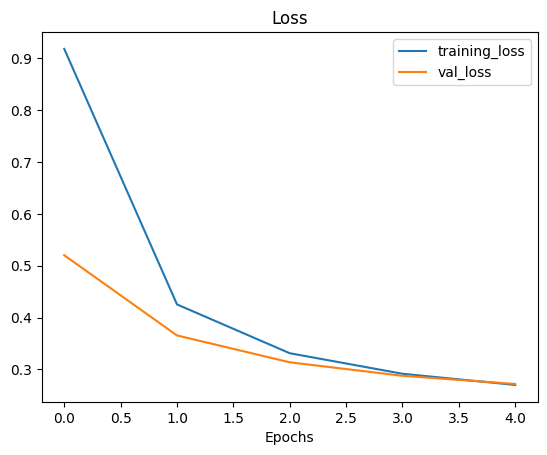

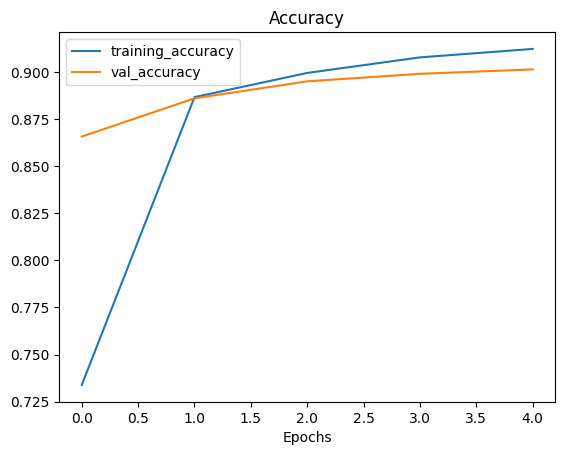

In [28]:
plot_loss_curves(history_1)

In [29]:
# Unfreeze all layers of the base model
base_model_EfficientNetB0.trainable= True

# Freeze all layers except the last 15 layer
for layer in base_model_EfficientNetB0.layers[:-15]:
    layer.trainable=False

# Recompile
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

In [30]:
#Fine tune for another 5 epochs
initial_epochs= 5
fine_tune_epochs=initial_epochs + 5

hisotory_2 = model_1.fit(train_data,
                                       epochs=fine_tune_epochs,
                                       validation_data=test_data,
                                       validation_steps=len(test_data),
                                       initial_epoch=history_1.epoch[-1],
                                       callbacks=[
                                  CheckpointCallback,
                                  Early_stopping,
                                  Learning_rate_reduction])

Epoch 5/10
439/439 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8986
Epoch 5: val_accuracy improved from 0.90133 to 0.91533, saving model to EfficientNetB0.h5
439/439 [==============================] - 505s 1s/step - loss: 0.3012 - accuracy: 0.8986 - val_loss: 0.2242 - val_accuracy: 0.9153 - lr: 1.0000e-04
Epoch 6/10
439/439 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9249
Epoch 6: val_accuracy improved from 0.91533 to 0.92333, saving model to EfficientNetB0.h5
439/439 [==============================] - 500s 1s/step - loss: 0.2108 - accuracy: 0.9249 - val_loss: 0.2046 - val_accuracy: 0.9233 - lr: 1.0000e-04
Epoch 7/10
439/439 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9378
Epoch 7: val_accuracy improved from 0.92333 to 0.92367, saving model to EfficientNetB0.h5
439/439 [==============================] - 495s 1s/step - loss: 0.1791 - accuracy: 0.9378 - val_loss: 0.1997 - val_accuracy: 0.9237 - lr: 1.0000

Fine tuning results

In [31]:
#compare histories
def compare_histories(history,new_history,initial_epochs):
    loss=history.history["loss"]
    val_loss=history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs=range(len(history.history["loss"])+len(new_history.history["loss"]))

    total_acc= accuracy+ new_history.history["accuracy"]
    total_loss=loss+ new_history.history["loss"]

    total_val_acc= val_accuracy + new_history.history["val_accuracy"]
    total_val_loss=val_loss+ new_history.history["val_loss"]

    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc ,label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation accuracy")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training_loss")
    plt.plot(total_val_loss, label="Val_loss")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation Loss")
    plt.legend()

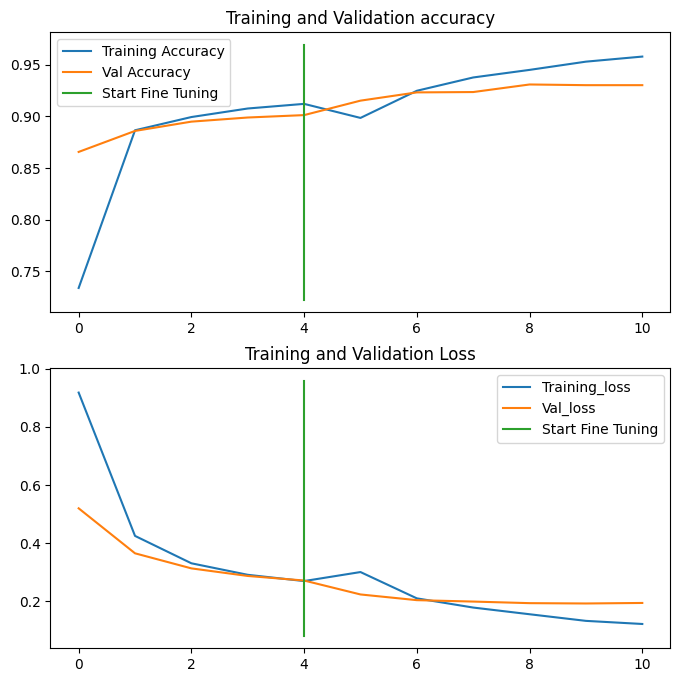

In [32]:
compare_histories(history_1,hisotory_2,5)

**Prediction with test dataset, not seen by the model**

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 76s 806ms/step - loss: 0.1949 - accuracy: 0.9303


[0.1949428915977478, 0.9303333163261414]

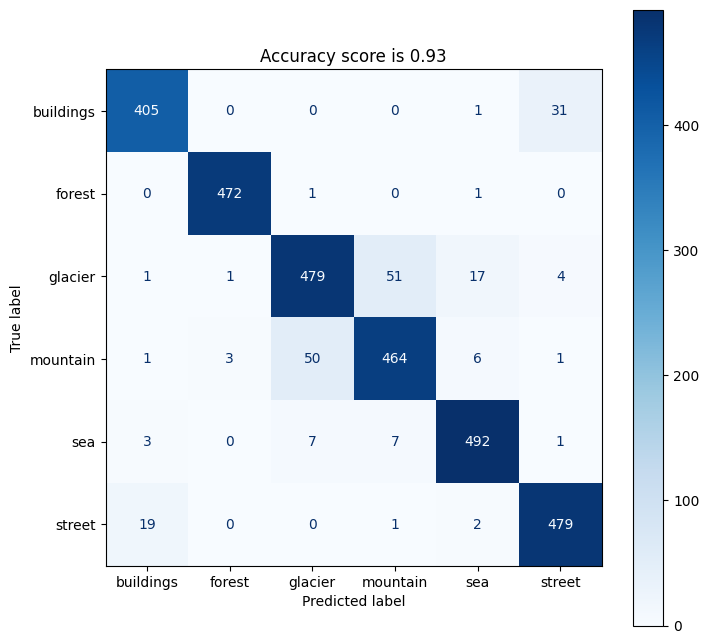

In [34]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(model_1, test_ds1)
plot_confMat(y_true, y_pred)

model_1.evaluate(test_ds1)

**Prediction dataset**

1/1 [==============================] - 0s 72ms/step


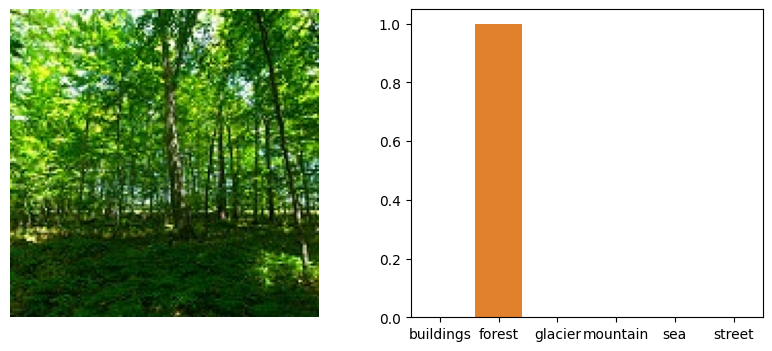

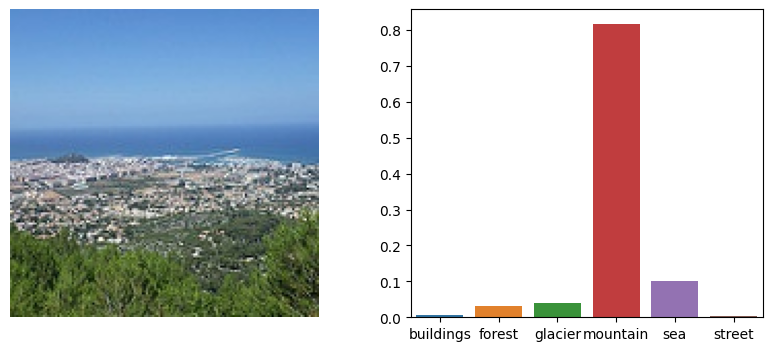

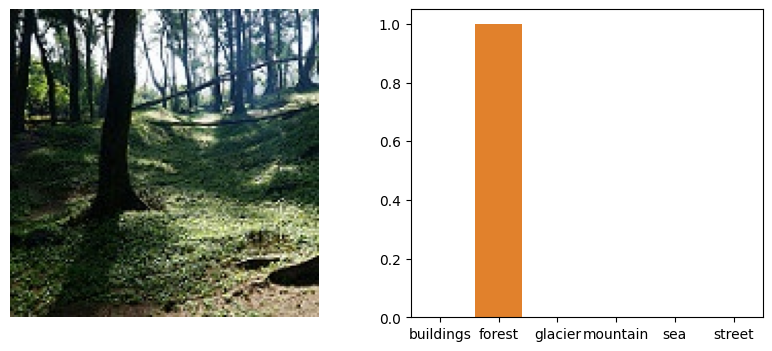

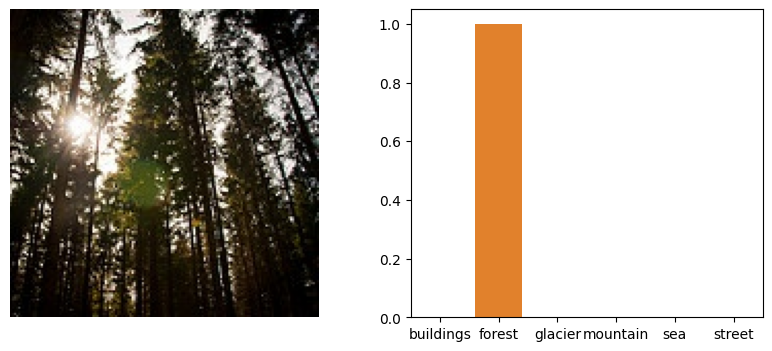

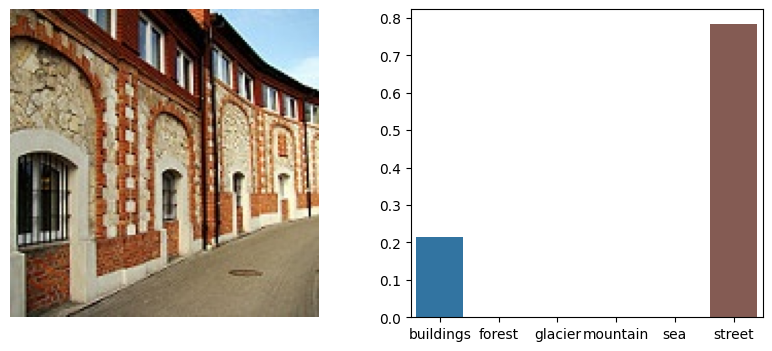

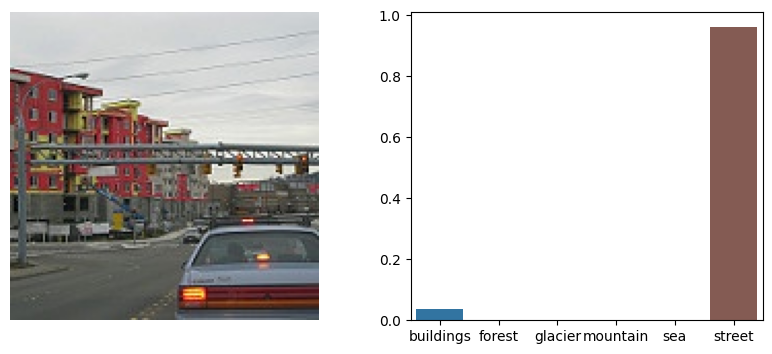

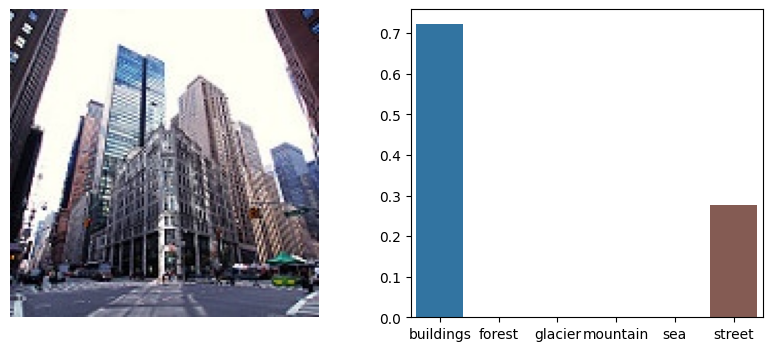

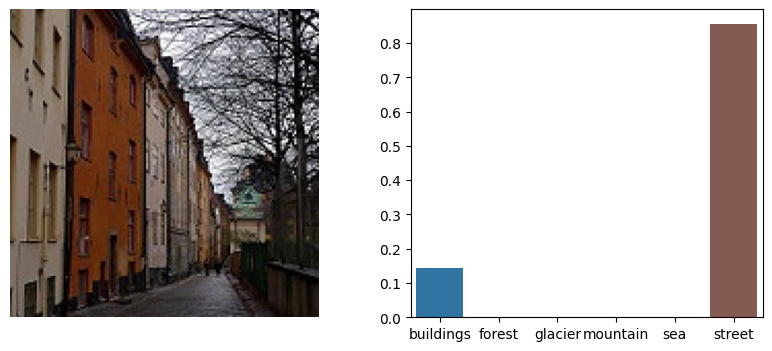

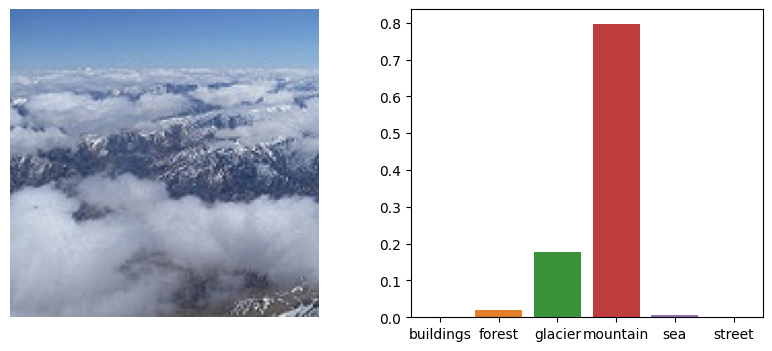

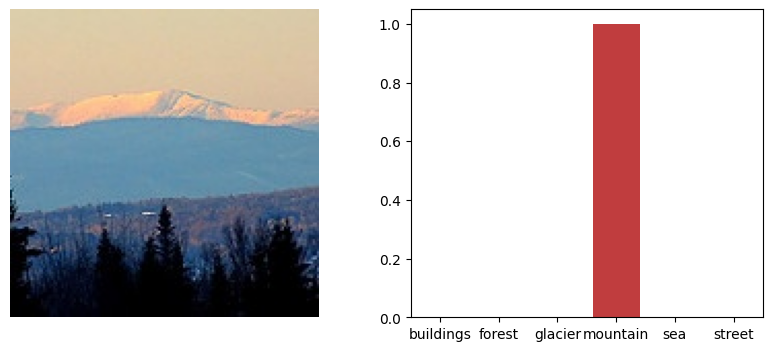

In [37]:
sp = sample_prediction_images(dir_pred, fnames_pred, 10)
for spj in sp:
    read_prepare_image_predict(spj,model_1)